# Countries

- Data Cleaning
- Data Visualisation
- Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [3]:
# Reading the data from countries revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/countries_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/countries.csv')

In [5]:
print("Number of Revisions in Countries Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Countries Dataset")
print(items.shape)

Number of Revisions in Countries Dataset
(3503629, 12)
Number of Wikidata Items in Countries Dataset
(673486, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [6]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [8]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [9]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [11]:
rev.shape

(3503629, 9)

In [12]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [14]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [16]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [17]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [19]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [20]:
editscount = rev['qid'].value_counts()

In [21]:
editscount.describe()

count    671581.000000
mean          5.190891
std          12.548644
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         657.000000
Name: qid, dtype: float64

These statistics are already different from the politics dataset as the highest here is 657 wheras in politics it was 1431 at this point but the item with 1431 edits was the sandbox so reverify this. However in the politics dataset the 75th quartile had a value of 8 wheras here the value is much lower - 3. Thus there are very few items with a high number of edits.

Rationale for Removing edits <= 5

- Research
- Range of edits is very large
- Median value that is the 50th percentile is 3 edits that is more than half the dataset has items that would not be very interesting to the research as we are interested in highly edited items
- Items in the 75th percentile have an editcount of 8 showing that only a small percentage of items - slightly greater than 25% of the items are those that can be deemed interesting
- Also important to note that given these values, the data could also contain a reasonable number of outliers - items which are highly edited but do not add value to the research - for example they do not contain reverts or they are sandbox items

In [22]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [24]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
253204
Items with No of Edits = 2
211409
Items with No of Edits = 3
58056
Items with No of Edits = 4
22926
Items with No of Edits = 5
25572
Items with No of Edits <= 5
571167


In [25]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [26]:
df_editscount.shape

(100414, 2)

In [27]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [29]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [30]:
# To query info based on datetime remember to input dates in complete formatting
# rev[rev['timestamp'] >= '2016-10-01 00:00:00']

Imp to parse timestamps as you would potentially be interested in looking at the time difference between edits in the future, difference between datetime objects can be found using timedelta from datetime.

In [31]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [32]:
# Sparql Query to get labels using Qids
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [38]:
print(df_editscount.head())

      qid  editscount
0   Q1085         657
1    Q649         468
2    Q656         413
3  Q14960         279
4  Q34600         201


# Descriptive Statistics

In [39]:
rev['editscount'].describe().astype(int)

count    2416350
mean          50
std           28
min            6
25%           19
50%           64
75%           65
max          657
Name: editscount, dtype: int32

In [40]:
rev['type'].describe()

count     2416350
unique         10
top           add
freq      1886149
Name: type, dtype: object

In [41]:
countries_items = rev['qid'].value_counts()

In [44]:
# converting a series to a dataframe
c_items = pd.DataFrame({'type':countries_items.index, 'count':countries_items.values})

In [46]:
# Items between the median and 75th percentile
c_items[(c_items['count'] >= 64) & (c_items['count'] <= 65)]

,type,count
8217,Q1222619,65
8218,Q1064250,65
8219,Q281103,65
8220,Q613919,65
8221,Q519403,65
...,...,...
19188,Q770405,64
19189,Q1102607,64
19190,Q1134787,64
19191,Q1166889,64


# Statistics for Proxies

In [47]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [48]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

           count
type            
add      1886149
update    264110
create    161238
remove     81298
set        20631
undo        1590
merge        730
revert       397
restore      203
protect        4


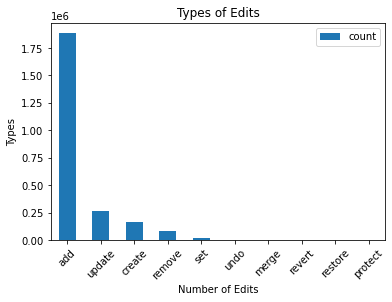

In [49]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

According to the bar plot the proxy with the highest occurrence is add followed by create, update, remove, set and those with no types specified (those without any comments). 

This was expected behaviour as this infers that editors are adding a lot of information to wikidata over a period of time. As we are exploring controversies in wikidata, the remaining edits namely - reverts, undos, removes, merges, restores and protect will be more useful thus we will visualise those.

Standard/Expected behaviour as seen in politics.

In [50]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

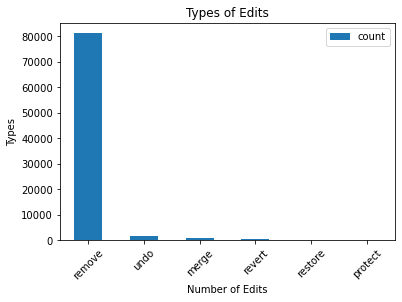

In [51]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

In [52]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
undo      1590
merge      730
revert     397
restore    203
protect      4


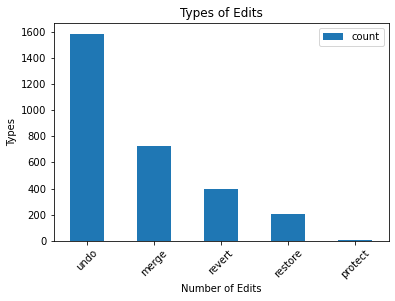

In [53]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

# Statistics for No of Edits

In [55]:
no_of_edits = countries_items.to_numpy()

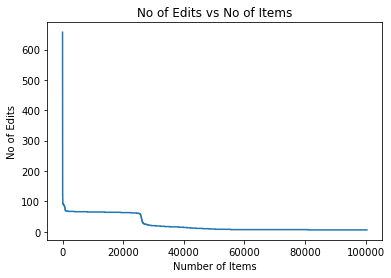

In [56]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

Similar to politics except there is a difference in the number of edits and the number of items. Behavious of the line plot is similar.

Very few items in the dataset have a high number of edits that is greater than 75% which was no of edits = 65

# Top 25% of the Dataset?

# Grouping by Proxies

In [57]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [58]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [59]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [60]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [61]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [62]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [71]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [72]:
proxies = proxies.reset_index()

In [73]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [74]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [75]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [77]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [78]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [80]:
proxies.head()

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
0,Q2123546,0,0,0,0,0,0,6,3
1,Q2123580,0,0,0,0,0,0,7,3
2,Q2123765,0,0,0,0,0,0,8,5
3,Q2123937,0,0,0,0,0,0,6,4
4,Q2124144,0,0,0,0,0,0,7,4


In [81]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000,100414.000000
mean,0.003954,0.007270,0.015834,0.002022,0.000040,0.809628,24.063876,2.408907
std,0.089894,0.087038,0.162049,0.055436,0.006311,2.122363,25.062927,1.788717
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,3.000000
max,7.000000,3.000000,8.000000,4.000000,1.000000,137.000000,657.000000,51.000000


Observations:

- Highest userscount is 51 whereas in the politics dataset it was 122

Text(0, 0.5, 'No of Edits')

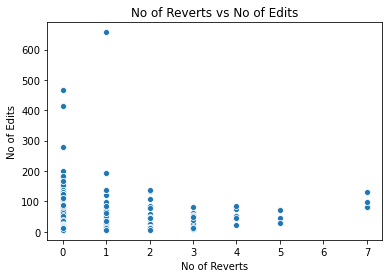

In [82]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")
# No of reverts are very low for highly edited items

3 items which have a high number of reverts and have edits that are potentially above the 75th quartile - highly edited/in the top 25% - interesting as politics only had 1 item like that

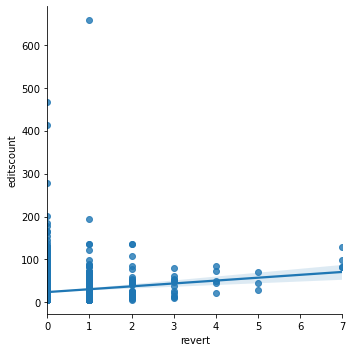

In [83]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [84]:
corr_matrix = proxies.corr()
corr_matrix
# merge and editscount have a negative correlation
# undo and editscount
# remove and editscount 
# more items have a weak negative correlation than in politics


,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,0.019237,0.200114,0.324136,0.105041,0.026025,0.024045,0.279803
merge,0.019237,1.000000,0.032791,0.044425,0.017602,0.024313,-0.036991,0.084213
undo,0.200114,0.032791,1.000000,0.169376,0.087019,-0.002412,-0.026349,0.172882
restore,0.324136,0.044425,0.169376,1.000000,0.142087,0.047286,0.022177,0.179974
protect,0.105041,0.017602,0.087019,0.142087,1.000000,0.005027,0.014779,0.090301
remove,0.026025,0.024313,-0.002412,0.047286,0.005027,1.000000,-0.046370,-0.043306
editscount,0.024045,-0.036991,-0.026349,0.022177,0.014779,-0.046370,1.000000,-0.187066
userscount,0.279803,0.084213,0.172882,0.179974,0.090301,-0.043306,-0.187066,1.000000


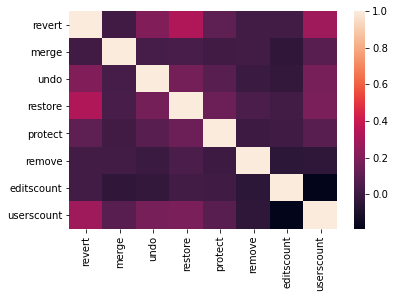

In [85]:
sns.heatmap(corr_matrix)

In [ ]:
# revert and restore
# userscount and revert but very weak positive
# no of edits and no of users is negatively correlated

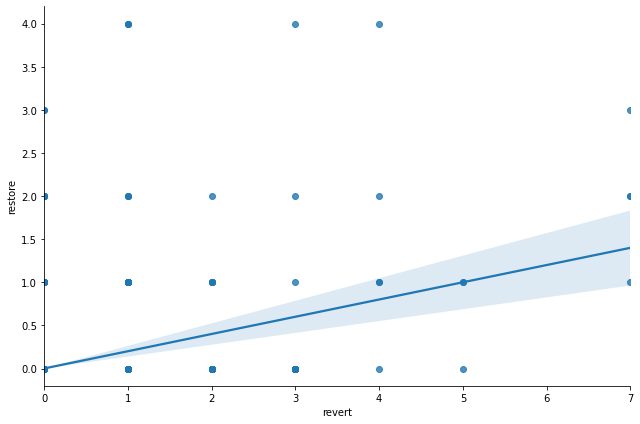

In [86]:
# restore and revert have some correlation - weak positive
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

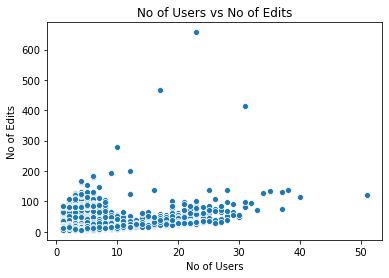

In [87]:
# userscount and editscount have a weak negative correlation - although not very high - it is much higher than others
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

In [88]:
# Quite different as compared to politics 
# Politics has more items which had a high number of edits from fewer users
# But also the number of users is considerably less
# As compared to politics
# the more number of users are contributing to a lot of the
# items which are highly edites

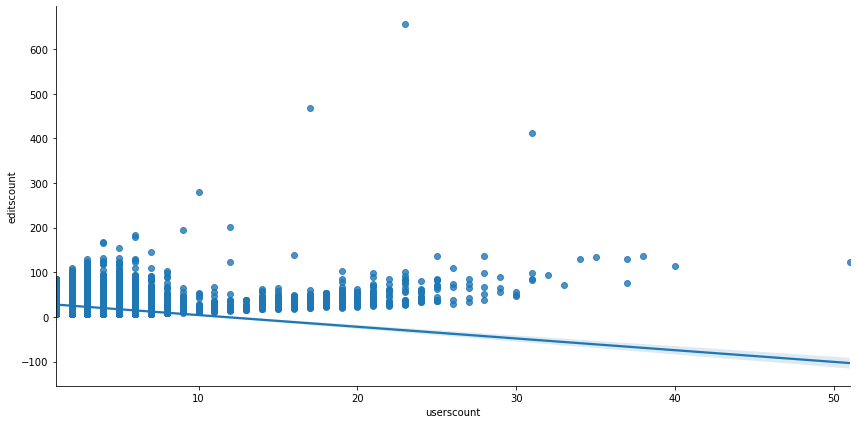

In [89]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [91]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
# Removing items with editscount <= 5 
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [92]:
proxies.shape

(19936, 9)